In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Activation, Conv1D, MaxPooling1D, Flatten, Bidirectional
from keras.layers.merge import concatenate
from keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from dataprep import get_vectors, get_data

import tensorflow as tf
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings('ignore')

In [2]:
# To calculate on GPU
# https://github.com/tensorflow/tensorflow/issues/33721
TF_FORCE_GPU_ALLOW_GROWTH=1
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [3]:
# CONSTANTS
seed = 42
lr = 0.0001
batch = 32

In [4]:
cmt_pos = pd.read_csv('../../data/prepared/no_trans_stem_pos.csv')
cmt_neg = pd.read_csv('../../data/prepared/no_trans_stem_neg.csv')
X, Y, vocab_size, emdedding_size, vectors = get_data(cmt_pos, cmt_neg, 3)
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=seed, test_size=0.3, stratify=Y, shuffle=True)
# check if the data is evenly split
import collections
print('Train labels: ', collections.Counter(y_train))
print('Test labels: ', collections.Counter(y_test))

Train labels:  Counter({1: 2206, 0: 2206})
Test labels:  Counter({1: 946, 0: 946})


In [5]:
# Cross validation setup
sk = StratifiedKFold(n_splits = 3, random_state = seed, shuffle = True) 

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4)

In [7]:
adamOptimizer = Adam(lr=lr)

In [8]:
def plot_history(history_arrs, train, val, xlabel, ylabel, plot_title):
    if len(history_arrs) == 1:
        history = history_arrs[0]
        plt.plot(history['accuracy'])
        plt.plot(history['val_accuracy'])
        plt.title(plot_title)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()
    else:
        f, a = plt.subplots(1, len(history_arrs), figsize=(10,5))
        for idx, history in enumerate(history_arrs):
            # For Sine Function
            a[idx].plot(history[train])
            a[idx].plot(history[val])
            title = plot_title + ' ' + str(idx)
            a[idx].set_title(title)
            a[idx].set_xlabel(xlabel)
            a[idx].set_ylabel(ylabel)
            a[idx].legend(['Train', 'Validation'], loc='upper left')
        f.tight_layout()
        plt.show()

In [9]:
def run_test(model_func, Xtrain, ytrain, X_test, y_test, embedding_layer):
    results = []
    histories = []
    best_model = None
    best_acc = 0
    for train_index, val_index in sk.split(X_train, y_train):
        Xt, Xv = Xtrain[train_index], Xtrain[val_index]
        yt, yv = ytrain[train_index], ytrain[val_index]
        model = model_func(embedding_layer)
        history = model.fit(Xt, yt, validation_data=(Xv, yv), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
        histories.append(history.history)
        loss, acc = model.evaluate(X_test, y_test, verbose = 0, batch_size=batch)
        if best_acc < acc:
            best_model = model
        results.append([loss, acc])
    results = np.array(results)
    return results, histories, model

In [10]:
def model_1(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(128, 2))
    model.add(MaxPooling1D(2))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer=adamOptimizer, metrics = ['accuracy'])
    return model

In [11]:
def calculate_metrics(model, X_test, y_test):
    ypred_class = model.predict_classes(X_test, verbose=0)
    ypred_class = ypred_class[:, 0]
    accuracy = accuracy_score(y_test, ypred_class)
    precision = precision_score(y_test, ypred_class)
    recall = recall_score(y_test, ypred_class)
    f1 = f1_score(y_test, ypred_class)
    conf_matrix = confusion_matrix(y_test, ypred_class)
    return accuracy, precision, recall, f1, conf_matrix

In [12]:
def print_conf_matrix(conf_matrix):
    cm = pd.DataFrame(
    conf_matrix, 
    index=['true:positive', 'true:negative'], 
    columns=['pred:positive', 'pred:negative']
    )
    print(cm)

# Model 1

First model cross-validation without pretrained word vectors

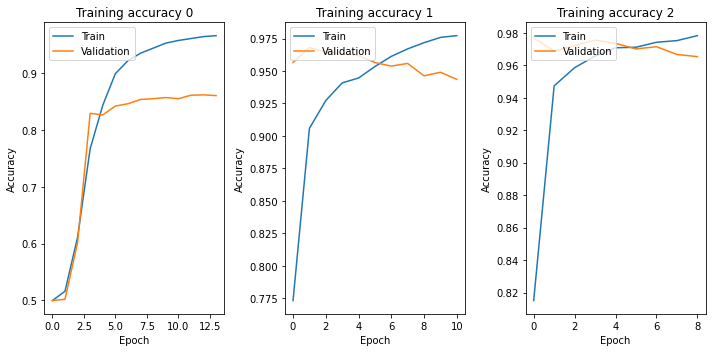

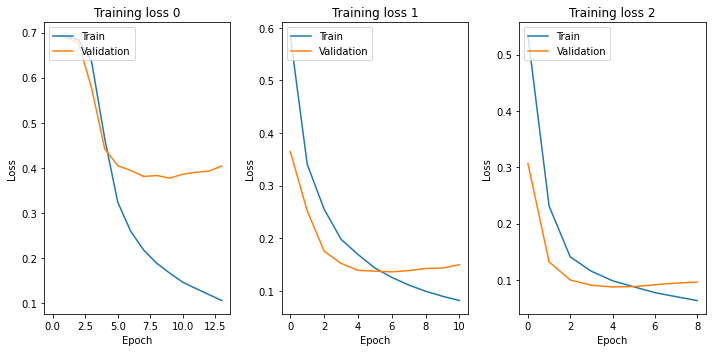

Average model 1 accuracy of cross validation on unseen data: 0.8638
The best perfoming model statistics with class predictions: 
Accuracy: 0.8710
Precision: 0.8634
Recall: 0.8816
F1 score: 0.8724
Confusion matrix:
               pred:positive  pred:negative
true:positive            814            132
true:negative            112            834


In [13]:
embedding_layer = Embedding(X.max()+1, 32, input_length=X.shape[1], trainable = True)
results, histories, model = run_test(model_1, X_train, y_train, X_test, y_test, embedding_layer)
# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Average model 1 accuracy of cross validation on unseen data: %.4f' % results[:, 1].mean())
print('The best perfoming model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

First model evaluation without pretrained word vectors

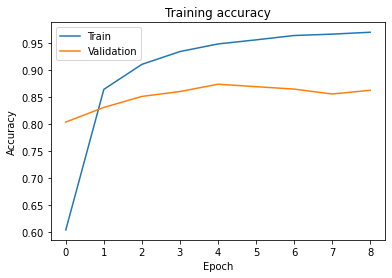

Model statistics with class predictions: 
Accuracy: 0.8790
Precision: 0.8953
Recall: 0.8584
F1 score: 0.8764
Confusion matrix:
               pred:positive  pred:negative
true:positive            851             95
true:negative            134            812


In [14]:
embedding_layer = Embedding(X.max()+1, 32, input_length=X.shape[1], trainable = True)
model = model_1(embedding_layer)
Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, random_state=seed, test_size=0.1, stratify=y_train, shuffle=True)
history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

In [15]:
# Save the model (weights, architecture)
model.save('../../models/models/cnnbilstm-nowv')

INFO:tensorflow:Assets written to: ../../models/models/cnnbilstm-nowv\assets


INFO:tensorflow:Assets written to: ../../models/models/cnnbilstm-nowv\assets


First model cross-validation with pretrained word vectors

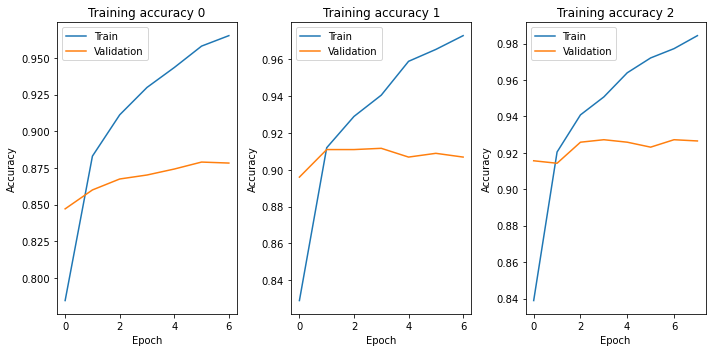

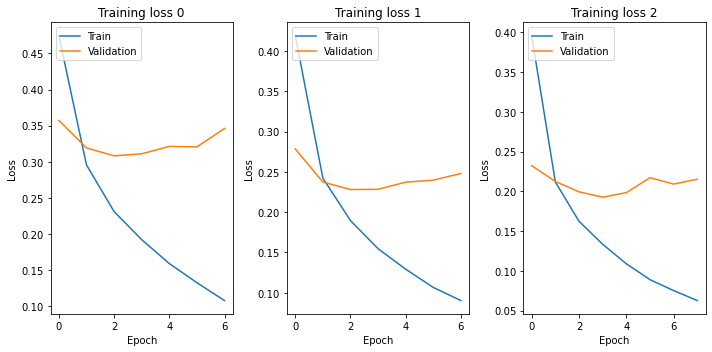

Average model 1 accuracy of cross validation on unseen data: 0.8834
The best perfoming model statistics: 
Accuracy: 0.8879
Precision: 0.8730
Recall: 0.9080
F1 score: 0.8902
Confusion matrix:
               pred:positive  pred:negative
true:positive            821            125
true:negative             87            859


In [16]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[vectors], trainable=True)
results, histories, model = run_test(model_1, X_train, y_train, X_test, y_test, embedding_layer)
# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Average model 1 accuracy of cross validation on unseen data: %.4f' % results[:, 1].mean())
print('The best perfoming model statistics: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

First model evaluation with pretrained word vectors

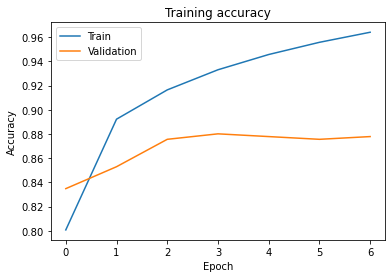

Model statistics with class predictions: 
Accuracy: 0.8975
Precision: 0.8925
Recall: 0.9038
F1 score: 0.8981
Confusion matrix:
               pred:positive  pred:negative
true:positive            843            103
true:negative             91            855


In [17]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[vectors], trainable=True)
model = model_1(embedding_layer)
Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, random_state=seed, test_size=0.1, stratify=y_train, shuffle=True)
history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

In [18]:
# Save the model (weights, architecture)
model.save('../../models/models/cnnbilstm-wv')

INFO:tensorflow:Assets written to: ../../models/models/cnnbilstm-wv\assets


INFO:tensorflow:Assets written to: ../../models/models/cnnbilstm-wv\assets


## Model 2

In [19]:
def model_2(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(128, 2))
    model.add(MaxPooling1D(2))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.1))
    model.add(Dense(32))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer=adamOptimizer, metrics = ['accuracy'])
    return model

Second model cross-validation without pretrained word vectors

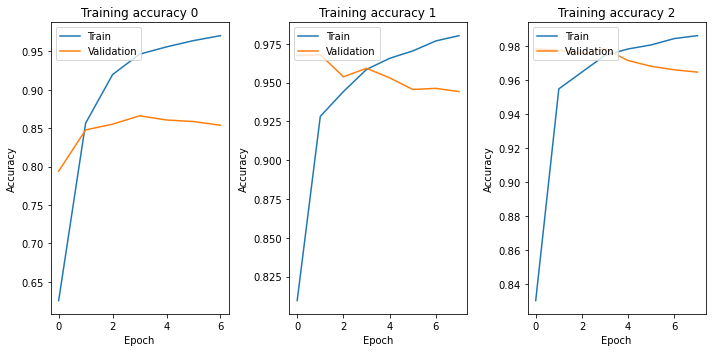

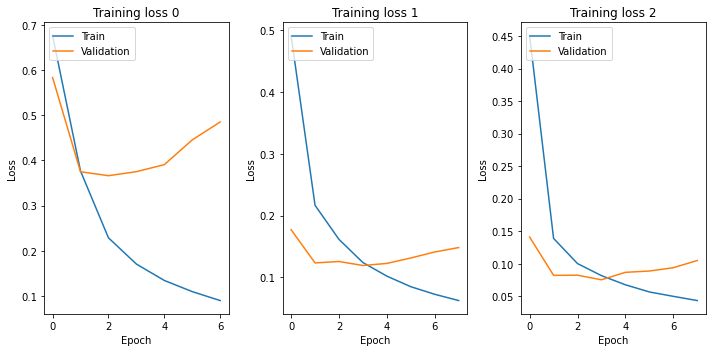

Average model 2 accuracy of cross validation on unseen data: 0.8635
The best perfoming model statistics with class predictions: 
Accuracy: 0.8710
Precision: 0.8703
Recall: 0.8721
F1 score: 0.8712
Confusion matrix:
               pred:positive  pred:negative
true:positive            823            123
true:negative            121            825


In [20]:
embedding_layer = Embedding(X.max()+1, 32, input_length=X.shape[1], trainable = True)
results, histories, model = run_test(model_2, X_train, y_train, X_test, y_test, embedding_layer)
# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Average model 2 accuracy of cross validation on unseen data: %.4f' % results[:, 1].mean())
print('The best perfoming model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

Second model evaluation without pretrained word vectors

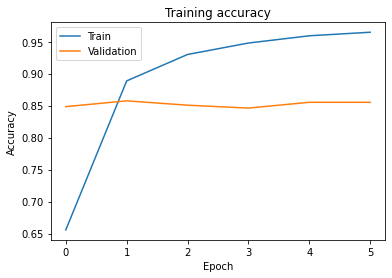

Model statistics with class predictions: 
Accuracy: 0.8753
Precision: 0.8834
Recall: 0.8647
F1 score: 0.8739
Confusion matrix:
               pred:positive  pred:negative
true:positive            838            108
true:negative            128            818


In [21]:
embedding_layer = Embedding(X.max()+1, 32, input_length=X.shape[1], trainable = True)
model = model_2(embedding_layer)
Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, random_state=seed, test_size=0.1, stratify=y_train, shuffle=True)
history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

In [22]:
# Save best performing model (weights, architecture)
model.save('../../models/models/cnnbilstm2-nowv')

INFO:tensorflow:Assets written to: ../../models/models/cnnbilstm2-nowv\assets


INFO:tensorflow:Assets written to: ../../models/models/cnnbilstm2-nowv\assets


Second model cross-validation with pretrained word vectors

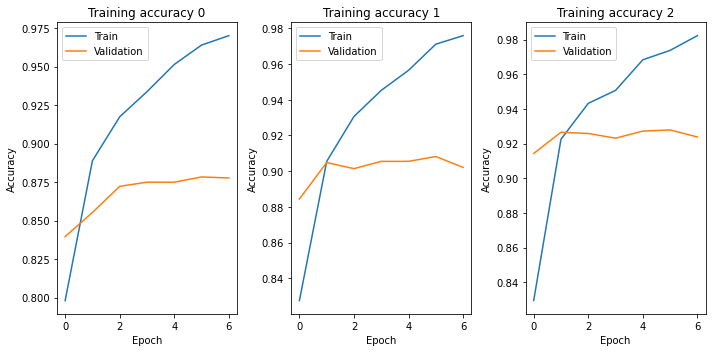

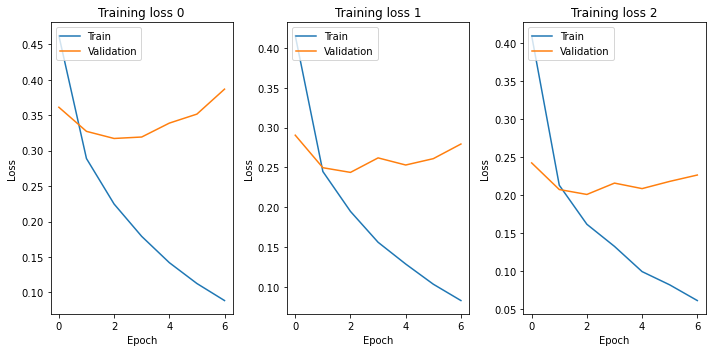

Average model 2 accuracy of cross validation on unseen data: 0.8844
The best perfoming model statistics: 
Accuracy: 0.8911
Precision: 0.8822
Recall: 0.9027
F1 score: 0.8924
Confusion matrix:
               pred:positive  pred:negative
true:positive            832            114
true:negative             92            854


In [23]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[vectors], trainable=True)
results, histories, model = run_test(model_2, X_train, y_train, X_test, y_test, embedding_layer)
# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Average model 2 accuracy of cross validation on unseen data: %.4f' % results[:, 1].mean())
print('The best perfoming model statistics: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

Second model evaluation pretrained with pretrained word vectors

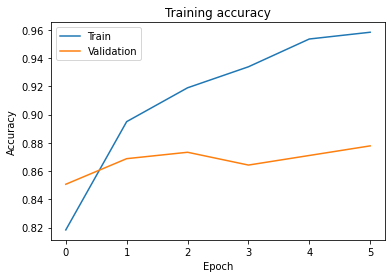

Model statistics with class predictions: 
Accuracy: 0.8858
Precision: 0.8891
Recall: 0.8816
F1 score: 0.8854
Confusion matrix:
               pred:positive  pred:negative
true:positive            842            104
true:negative            112            834


In [24]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[vectors], trainable=True)
model = model_2(embedding_layer)
Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, random_state=seed, test_size=0.1, stratify=y_train, shuffle=True)
history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

In [25]:
model.save('../../models/models/cnnbilstm2-wv')

INFO:tensorflow:Assets written to: ../../models/models/cnnbilstm2-wv\assets


INFO:tensorflow:Assets written to: ../../models/models/cnnbilstm2-wv\assets


# Model architecture tests on IMDB dataset

In [35]:
# IMDB dataset
from keras.datasets import imdb
word_count = 5000
skip_words = 20
(X_train_imdb, y_train_imdb), (X_test_imdb, y_test_imdb) = imdb.load_data(num_words=word_count, skip_top = skip_words)
max_length = 500
X_train_imdb = sequence.pad_sequences(X_train_imdb, maxlen=max_length)
X_test_imdb = sequence.pad_sequences(X_test_imdb, maxlen=max_length)

## Model 1

First model performance evaluation with cross-validation

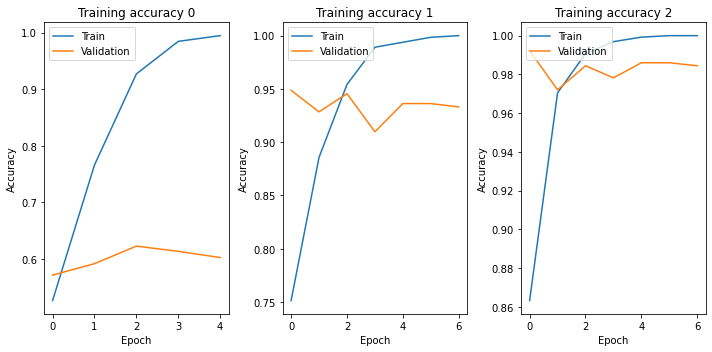

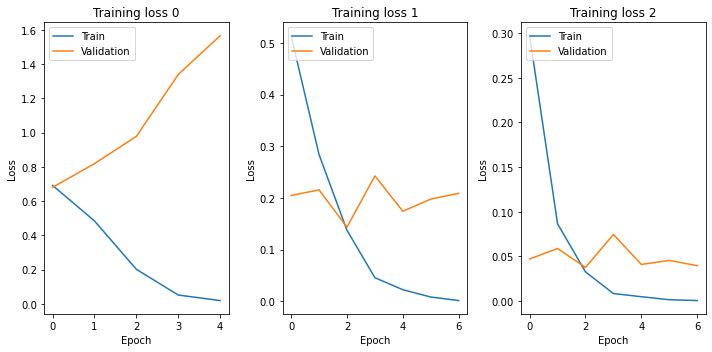

Average model 1 accuracy of cross validation on unseen IMDB data: 0.6975
The best perfoming model statistics: 
Accuracy: 0.7295
Precision: 0.7185
Recall: 0.7546
F1 score: 0.7361
Confusion matrix:
               pred:positive  pred:negative
true:positive           8804           3696
true:negative           3067           9433


In [38]:
embedding_layer = Embedding(word_count, 32, input_length=max_length, trainable=True)
results, histories, model = run_test(model_1, X_train_imdb, y_train_imdb, X_test_imdb, y_test_imdb, embedding_layer)
# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test_imdb, y_test_imdb)
print('Average model 1 accuracy of cross validation on unseen IMDB data: %.4f' % results[:, 1].mean())
print('The best perfoming model statistics: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

First model performance evaluation without cross-validation

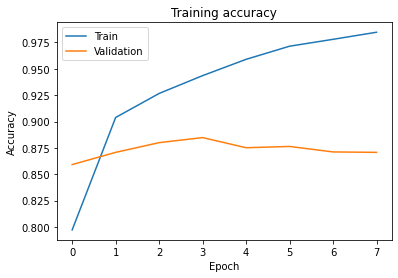

Model statistics with class predictions: 
Accuracy: 0.8675
Precision: 0.8797
Recall: 0.8514
F1 score: 0.8653
Confusion matrix:
               pred:positive  pred:negative
true:positive          11045           1455
true:negative           1858          10642


In [37]:
embedding_layer = Embedding(word_count, 32, input_length=max_length)
model = model_1(embedding_layer)
Xtrain_imdb, Xval_imdb, ytrain_imdb, yval_imdb = train_test_split(X_train_imdb, y_train_imdb, random_state=seed, test_size=0.1, stratify=y_train_imdb, shuffle=True)
history = model.fit(Xtrain_imdb, ytrain_imdb, validation_data=(Xval_imdb, yval_imdb), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test_imdb, y_test_imdb)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

## Model 2

Second model performance evaluation with cross-validation

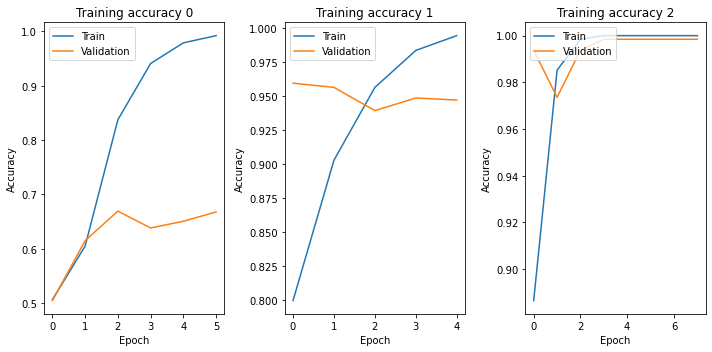

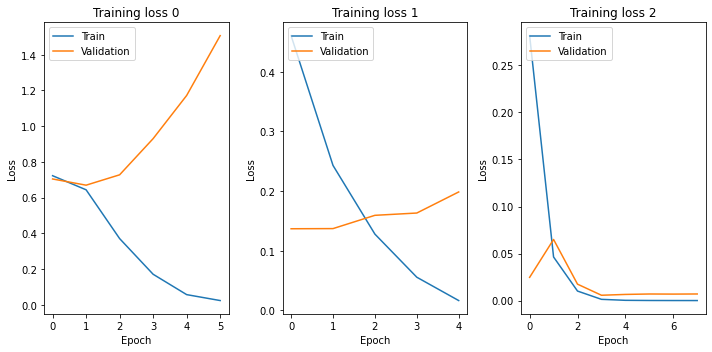

Average model 2 accuracy of cross validation on unseen IMDB data: 0.7169
The best perfoming model statistics: 
Accuracy: 0.7366
Precision: 0.7251
Recall: 0.7622
F1 score: 0.7432
Confusion matrix:
               pred:positive  pred:negative
true:positive           8888           3612
true:negative           2973           9527


In [33]:
embedding_layer = Embedding(word_count, 32, input_length=max_length)
results, histories, model = run_test(model_2, X_train_imdb, y_train_imdb, X_test_imdb, y_test_imdb, embedding_layer)
# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test_imdb, y_test_imdb)
print('Average model 2 accuracy of cross validation on unseen IMDB data: %.4f' % results[:, 1].mean())
print('The best perfoming model statistics: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

Second model performance evaluation without cross-validation

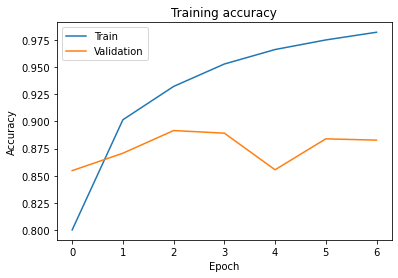

Model 2 statistics with class predictions: 
Accuracy: 0.8738
Precision: 0.8603
Recall: 0.8924
F1 score: 0.8761
Confusion matrix:
               pred:positive  pred:negative
true:positive          10689           1811
true:negative           1345          11155


In [34]:
embedding_layer = Embedding(word_count, 32, input_length=max_length)
model = model_2(embedding_layer)
Xtrain_imdb, Xval_imdb, ytrain_imdb, yval_imdb = train_test_split(X_train_imdb, y_train_imdb, random_state=seed, test_size=0.1, stratify=y_train_imdb, shuffle=True)
history = model.fit(Xtrain_imdb, ytrain_imdb, validation_data=(Xval_imdb, yval_imdb), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test_imdb, y_test_imdb)
print('Model 2 statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)